# MILB - Check Retention Distribution
* StellarAlgo
* Ryan Kazmerik
* August 2, 2022

In [2]:
import boto3 
import json
import matplotlib.pyplot as plt
import pandas as pd
import psycopg2

from pycaret.classification import *
from shared_utilities import helpers

In [ ]:
from importlib import reload
reload(helpers)

### Let's grab the training and eval datasets currently in prod:

In [3]:
df_train = pd.read_csv("./data/train.csv")
df_eval = pd.read_csv("./data/eval.csv")

### Let's setup our new model:

In [4]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    date_features=[
        "recentDate"
    ],
    ignore_features=[
        "dimCustomerMasterId",
        "productGrouping",
        "year"
    ],
    numeric_features=[
        "attendancePercent", 
        "distToVenue",
        "missed_games_1",
        "missed_games_2",
        "missed_games_over_2",
        "recency",
        "renewedBeforeDays",
        "source_tenure",
        "totalSpent"
    ],
    silent=True,
    verbose=False
);

best_model = compare_models(
    fold=10,
    include=["lightgbm"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7613,0.8391,0.7346,0.7276,0.7311,0.5164,0.5165,0.8760


### Let's finalize our new model so it can be used to make predictions:

In [5]:
final_model = create_model(best_model)
new_model = finalize_model(final_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7639,0.8438,0.7398,0.7296,0.7347,0.5221,0.5221
1,0.7547,0.8355,0.7320,0.7183,0.7251,0.5037,0.5038
2,0.7574,0.8364,0.7352,0.7211,0.7281,0.5092,0.5093
3,0.7613,0.8414,0.7196,0.7346,0.7270,0.5150,0.5151
4,0.7554,0.8305,0.7274,0.7213,0.7243,0.5046,0.5046
5,0.7630,0.8428,0.7345,0.7305,0.7325,0.5198,0.5198
6,0.7655,0.8412,0.7437,0.7304,0.7369,0.5254,0.5255
7,0.7610,0.8385,0.7319,0.7284,0.7302,0.5157,0.5157
8,0.7675,0.8424,0.7420,0.7344,0.7382,0.5291,0.5291
9,0.7626,0.8379,0.7401,0.7273,0.7336,0.5196,0.5196


### Let's also load in the model currently being used in production:

In [6]:
prod_model = load_model('./models/model(2022-05-12)')

Transformation Pipeline and Model Successfully Loaded


### Let's use the new and existing model to make predictions on the 2022 season:

In [7]:
df_inference = pd.read_csv("./data/inference.csv")
df_inference.columns=['attendancePercent','clientcode','dimcustomermasterid','distToVenue','isNextYear_Buyer','lkupclientid','missed_games_1','missed_games_2','missed_games_over_2','productGrouping','recency','recentDate','renewedBeforeDays','source_tenure','totalSpent','year']

df_inference = df_inference.loc[df_inference['lkupclientid']==15]

In [8]:
df_new_predictions = predict_model(new_model, data=df_inference, raw_score=True)
df_prod_predictions = predict_model(prod_model, data=df_inference, raw_score=True)

### Let's try normalizing the scores between a range of 0 and 1:

In [9]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [10]:
df_new_predictions["Score_1"] = df_new_predictions["Score_1"] * 100
df_new_predictions["Score_1"] = NormalizeData(df_new_predictions["Score_1"])

df_new_predictions["Score_1"].value_counts(bins=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])

(0.2, 0.3]       317
(0.1, 0.2]       278
(0.3, 0.4]       186
(0.4, 0.5]       156
(-0.001, 0.1]    103
(0.5, 0.6]        95
(0.6, 0.7]        81
(0.7, 0.8]        55
(0.8, 0.9]        46
(0.9, 1.0]        14
Name: Score_1, dtype: int64

In [12]:
df_prod_predictions["Score_1"] = df_prod_predictions["Score_1"] * 100
df_prod_predictions["Score_1"] = NormalizeData(df_prod_predictions["Score_1"])

df_prod_predictions["Score_1"].value_counts(bins=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])

(0.4, 0.5]       212
(0.3, 0.4]       204
(0.5, 0.6]       202
(0.6, 0.7]       202
(0.2, 0.3]       150
(0.7, 0.8]       125
(0.1, 0.2]        96
(0.8, 0.9]        79
(-0.001, 0.1]     52
(0.9, 1.0]         9
Name: Score_1, dtype: int64

### Let's have a look at the distribution of scores for both models:

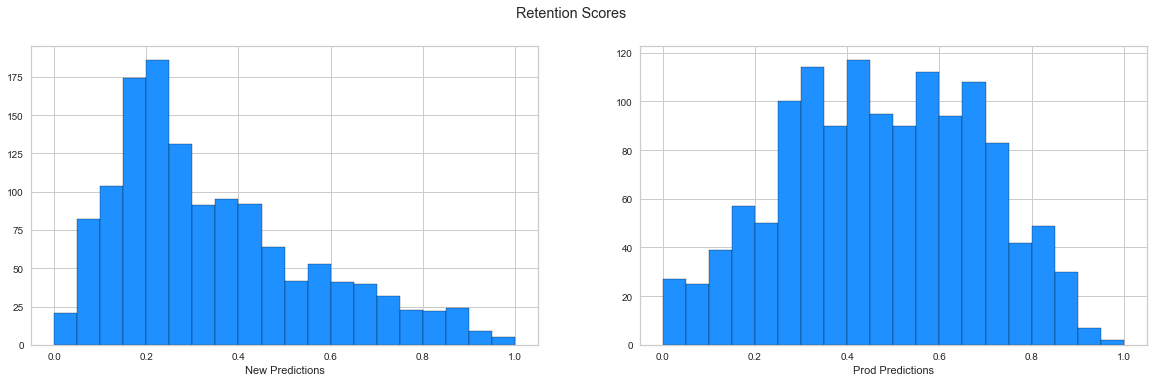

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Retention Scores')
ax1.hist(df_new_predictions['Score_1'], bins=20, edgecolor='black', color='dodgerblue')
ax2.hist(df_prod_predictions['Score_1'], bins=20, edgecolor='black', color='dodgerblue')
ax1.set_xlabel('New Predictions')
ax2.set_xlabel('Prod Predictions')

fig.figure.set_figwidth(20)

### Done